# Weather Forecast LSTM 
## Variabel: PRESIPITASI (PRECTOTCORR)
#### Pujo Prayogo 140810200038 <br>

Best Hyperparameter: <br>
    LSTM Layers   : 1<br> 
    Unit          : 128<br>
    Activation    : tanh <br>
    Learning Rate : 0.01<br>
    MAE Score     : 0.00029029781580902636<br>

R2 Score      : 0.9964505341173552 <br>
MAPE Score    : 0.7169951050127463%

In [1]:
import pandas as pd
import numpy as np
import keras_tuner
import requests
import json
import matplotlib.pyplot as plt
import keras_tuner as kt
import model
import shutil
import os

from datetime import timedelta, datetime
from statsmodels.tsa.stattools import acf

from scikeras.wrappers import KerasRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.activations import relu, tanh, sigmoid
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Flatten, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Import Data

1. Define fitur variabel, tanggal, dan koordinat lokasi
2. Import data cuaca melalui API POWER NASA
3. Konversi data JSON menjadi DataFrame

In [2]:
# ----- Parameter 
feature = "PRECTOTCORR"  # Variabel: GWETROOT, WS10M, PS, PRECTOTCORR, RH2M, T2M

# ----- Data dan metric/satuannya
renamed_dict = {
    "GWETROOT": "Kelembaban Tanah",
    "WS10M": "Kecepatan Angin",
    "PS": "Tekanan Permukaan",
    "PRECTOTCORR": "Presipitasi",
    "RH2M": "Kelembaban Udara",
    "T2M": "Temperatur"
}

feature_name = renamed_dict[feature]  # Rename variabel fitur

metrics_dict = {
    "GWETROOT": "", #Hanya 0-1
    "WS10M": "m/s",
    "PS": "kPa",
    "PRECTOTCORR": "mm/day",
    "RH2M": "C",
    "T2M": "g/kg"
}

# ----- Tanggal dan Koordinat lokasi data pada POWER NASA
start_date = "20190101"
end_date = "20231231"
lat = "-6.3968"
long = "106.8458"

# ----- Download Data melalui API POWER NASA
request_url = (
    f"https://power.larc.nasa.gov/api/temporal/daily/point?"
    f"start={start_date}&end={end_date}&latitude={lat}&longitude={long}&community=ag&"
    f"parameters={feature}&format=json&user=pujo&header=true&time-standard=lst"
)
response = requests.get(url=request_url, verify=True, timeout=30.00)
content = json.loads(response.content.decode('utf-8'))

# ----- Konversi data ke DataFrame
df = pd.DataFrame.from_dict(content['properties']['parameter'])
df.index = pd.to_datetime(df.index, format='%Y%m%d')

# ----- Rename Kolom
df.rename(columns={feature: feature_name}, inplace=True)

#### Pengecekan data null/invalid (-999)

In [3]:
# ----- Cek Data
print(df, '\n\n')
print(df.info(), '\n')

# ----- Cek Data Invalid (Bernilai -999)
invalid_data = (df == -999).sum().sum()
print("TIDAK ADA DATA INVALID" if invalid_data == 0 else f"TERDAPAT DATA INVALID SEBANYAK {invalid_data} DATA")

            Presipitasi
2019-01-01        14.68
2019-01-02         9.84
2019-01-03         6.52
2019-01-04         1.79
2019-01-05         5.75
...                 ...
2023-12-27        13.93
2023-12-28         2.98
2023-12-29         6.31
2023-12-30         3.18
2023-12-31        16.97

[1826 rows x 1 columns] 


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2019-01-01 to 2023-12-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Presipitasi  1826 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB
None 

TIDAK ADA DATA INVALID


#### Visualisasi data dalam grafik
Menampilkan grafik sebaran data

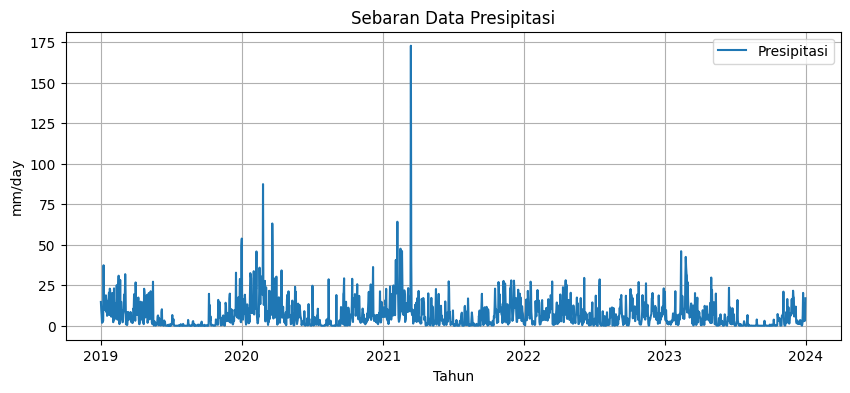

In [4]:
# ----- Visualisasi Data
plt.figure(figsize=(10, 4))
plt.plot(df.index, df[feature_name], label=feature_name)
plt.xlabel('Tahun')
plt.ylabel(metrics_dict[feature])  # Y-axis dinamis sesuai parameter
plt.title(f'Sebaran Data {feature_name}')
plt.grid(True)
plt.legend()
plt.show()

## Autokorelasi 
Menampilkan grafik autokorelasi dengan acf untuk menentukan timesteps.
Timesteps menurun secara konsisten sehingga diambil nilai acak sebagai timesteps, yaitu 30

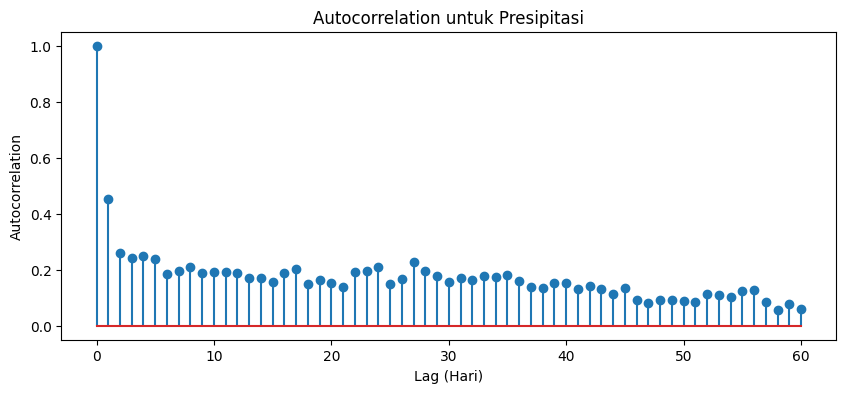

In [5]:
# ----- Autokorelasi untuk menentukan TImesteps
def determine_timesteps(df, max_lag=60):
    lag_acf = acf(df[feature_name], nlags=max_lag)

    # Visualisasi autokorelasi
    plt.figure(figsize=(10, 4))
    plt.stem(range(len(lag_acf)), lag_acf)
    plt.title(f'Autocorrelation untuk {feature_name}')
    plt.xlabel('Lag (Hari)')
    plt.ylabel('Autocorrelation')
    plt.show()

    return lag_acf

autocorrelation = determine_timesteps(df)

## Scaling data dengan MinMax

1. Scaling dengan MinMax
2. Pembagian data menjadi data Training (80%) dan data Testing (20%) tanpa mengubah urutan data
3. Visualisasi pembagian data training dan testing 

x' = x - min(x) / max(x) - min(x) <br>
x = Data original

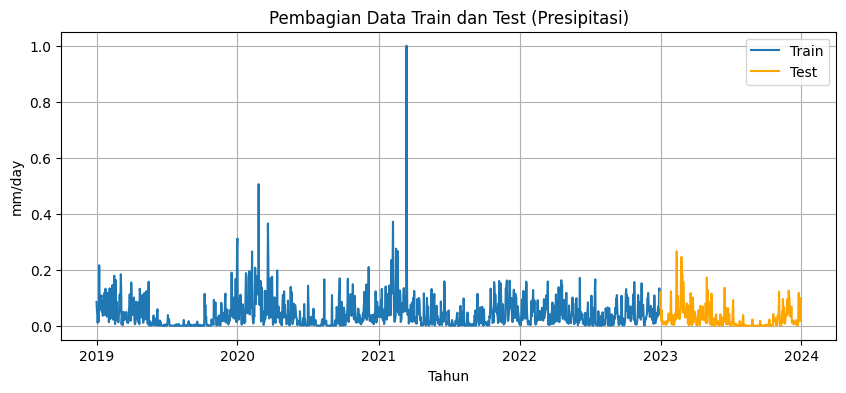

In [6]:
# ----- Scaling data dengan MinMax
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[[feature_name]])

# Train-Test Split (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_data, scaled_data, test_size=0.2, shuffle=False
)

# ----- Visualisasi Train-Test Split
plt.figure(figsize=(10, 4))
plt.plot(df.index[:len(X_train)], X_train, label='Train')
plt.plot(df.index[len(X_train):], X_test, label='Test', color='orange')
plt.xlabel('Tahun')
plt.ylabel(metrics_dict[feature])
plt.title(f'Pembagian Data Train dan Test ({feature_name})')
plt.grid(True)
plt.legend()
plt.show()

## Sequencing

1. Mendefinisikan timesteps
2. Membuat Fungsi untuk mempersiapkan data input yang sesuai format model LSTM.
   Data diubah menjadi sekuens sepanjang timesteps (30)
4. Reshaping data menjadi format 3D untuk input LSTM [jumlah_sekuens, timesteps, jumlah_fitur]

In [7]:
timesteps = 30

# ----- Fungsi Membuat Sequence 
def create_sequences(X, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(X[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test, timesteps)

# ----- Reshape untuk LSTM
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], 1))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], 1))

#### Membuat Directory untuk menyimpan hasil Tuning (Overwrite jika sudah ada) 

In [8]:
#Hapus Directory Tuning (hanya untuk Tuning ulang)
#tuning_dir = f'lstm_tuning_{feature_name}_dir'

#if os.path.exists(tuning_dir):
#    shutil.rmtree(tuning_dir)
#    print(f"Deleted previous tuning directory: {tuning_dir}")
#else:
#    print(f"Tuning directory not found: {tuning_dir}")

# Hyperparameter Tuning dengan KerasTuner
1. Membuat fungsi model LSTM:
   - Tuning jumlah layer LSTM (1 atau 2).
    - Tuning jumlah unit per layer (32, 64, atau 128).
    - Tuning fungsi aktivasi (relu, tanh, atau sigmoid).
    - Tuning optimizer (adam atau rmsprop) dan learning rate (0.01 atau 0.001).
2. Menambah Dropout (0.2) untuk mencegah overfitting
3. Inisiasi Tuner dengan trials sebanyak 72 kombinasi dan 1 eksekusi/trial
4. Mengaplikasikan callback EarlyStopping untuk menghentikan pelatihan jika tidak terdapat perbaikan selama 15 epochs berturut-turut

In [9]:
# ----- Fungsi membangun Model LSTM dengan Keras Tuner
def build_model(hp):
    model = Sequential()

    # ------ Jumlah Layers, jumlah unit, fungsi aktivasi
    for i in range(hp.Choice('layers', [1, 2])):  # Tuning layer LSTM (2)
        model.add(LSTM(
            units=hp.Choice('filters', [32, 64, 128]),  # Tuning jumlah unit pada layer LSTM (3) 
            activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid']),  # Tuning fungsi aktivasi (3)
            return_sequences=True if i < hp.Choice('layers', [1, 2]) - 1 else False  
        ))
        model.add(Dropout(0.2)) # Dropout
    model.add(Dense(1))
    
    # ----- Optimizer dan Learning Rate
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop']) # Tuning Optimizer (2)
    learning_rate = hp.Choice('learning_rate', [0.01, 0.001]) # Tuning learning Rate (2)
     
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)
    
    # ----- Compile Model
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return model

# --- Callback Early Stopping dengan Patience 15
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# ----- Inisiasi Tuner 
tuner = kt.GridSearch(
    build_model,
    objective='val_loss',
    max_trials=72,  # Jumlah Kombinasi Hyperparameter
    executions_per_trial=1,  # 2x training per kombinasi hyperparameter
    directory=f'lstm_tuning_{feature_name}_dir',
    project_name=f'lstm_{feature_name}_tuning'
)

Reloading Tuner from lstm_tuning_Presipitasi_dir\lstm_Presipitasi_tuning\tuner0.json


#### Tuning dengan epochs 200 dan patience Earlystopping 15

In [10]:
# ----- Hyperparameter Tuning
tuner.search(
    X_train_seq, y_train_seq,
    epochs=200,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stopping]
)

#### Output Hyperparameter Tuning (Konfigurasi terbaik & hasil seluruh Trials)

In [11]:
# ----- Output Best Hyperparameter
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
tuner_results = tuner.oracle.get_best_trials(num_trials=72)  
results = []

# Memasukkan Hasil Tuning ke DataFrame
for trial in tuner_results:
    values = trial.hyperparameters.values
    values['score'] = trial.score  # Nilai skor (mae)
    values['layers'] = trial.hyperparameters.get('layers')  # Menambahkan jumlah layer
    results.append(values)

df_results = pd.DataFrame(results)

# Tampilkan semua baris
pd.set_option('display.max_rows', None)  # Tampilkan semua baris
pd.set_option('display.max_columns', None)  # Tampilkan semua kolom

# Print Hyperparameter Terbaik
print("\n--- Setting Hyperparameter Terbaik ---")
print(f"Layer(s): {best_hps.get('layers')}")  # Menambahkan jumlah layer
print(f"Filters (units LSTM): {best_hps.get('filters')}")
print(f"Activation: {best_hps.get('activation')}")
print(f"Optimizer: {best_hps.get('optimizer')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Score (MAE): {best_hps.get('score')}\n\n")

# Print seluruh hasil hyperparameter tuning
print('Hasil Hyperparameter Tuning')
print(df_results)


--- Setting Hyperparameter Terbaik ---
Layer(s): 1
Filters (units LSTM): 32
Activation: relu
Optimizer: rmsprop
Learning Rate: 0.01
Score (MAE): 0.0009453472448512912


Hasil Hyperparameter Tuning
    layers  filters activation optimizer  learning_rate     score
0        1       32       relu   rmsprop          0.010  0.000945
1        1       64       relu      adam          0.010  0.000957
2        1      128       relu   rmsprop          0.010  0.000959
3        1      128       relu   rmsprop          0.001  0.000963
4        1       64       relu   rmsprop          0.001  0.000964
5        1       32       relu   rmsprop          0.001  0.000964
6        1      128       relu      adam          0.001  0.000965
7        1       32       tanh   rmsprop          0.010  0.000971
8        1       32       relu      adam          0.001  0.000974
9        1       32    sigmoid      adam          0.010  0.000974
10       1       64       tanh   rmsprop          0.010  0.000975
11       2

### Melatih ulang Model dengan Hyperparameter terbaik

In [12]:
# ----- Train Model dengan Hyperparameter terbaik
best_model = tuner.hypermodel.build(best_hps)

# --- LATIH ULANG MODEL DENGAN DATA TRAINING ---
history = best_model.fit(
    X_train_seq, y_train_seq,
    epochs=200,
    batch_size=32, 
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stopping]
)

Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0030 - mae: 0.0365 - val_loss: 0.0013 - val_mae: 0.0285
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021 - mae: 0.0312 - val_loss: 0.0012 - val_mae: 0.0267
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0039 - mae: 0.0344 - val_loss: 0.0013 - val_mae: 0.0280
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - mae: 0.0338 - val_loss: 0.0011 - val_mae: 0.0241
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0023 - mae: 0.0326 - val_loss: 0.0012 - val_mae: 0.0280
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0025 - mae: 0.0337 - val_loss: 0.0035 - val_mae: 0.0555
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0023 - mae: 0.0326 - val_loss: 0.0012 - val_mae: 0.0257
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0024 - mae: 0.0328 - val_loss: 0.0011 - val_mae: 0.0253
Epoch 9/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

## Evaluasi Model
Evaluasi Model menggunakan metric evaluasi R-Squared dan MAPE

R-Squared = seberapa baik model menjelaskan variasi dalam data
MAPE = tingkat kesalahan prediksi dengan persentase

R2 = 1 - (∑_(i=1)^n〖(yi-y ̂_i)〗^2 ) / (∑_(i=1)^n .〖(y_i-y ̅ )〗^2 ) <br>
MAPE = 1/n ∑_(i=1)^n |(y_i-y ̂_i)/y_i | 

In [13]:
# --- EVALUASI MODEL ---
y_pred = best_model.predict(X_test_seq)

# --- KEMBALIKAN SKALA PREDIKSI ---
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test_seq)

# --- HITUNG METRIK EVALUASI ---
r2 = r2_score(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"R-Squared: {r2}")
print(f"MAPE: {mape}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 
R-Squared: 0.3818139640109459
MAPE: inf%


C:\Users\Pujo Prayogo\AppData\Local\Temp\ipykernel_21896\3016109469.py:10: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100


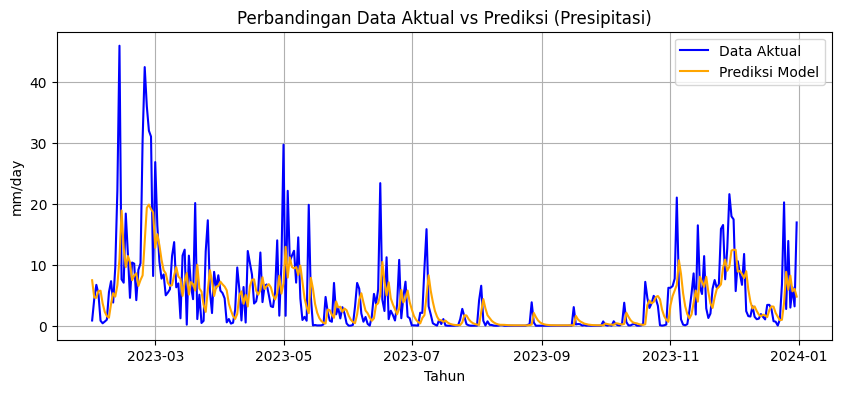

In [14]:
# --- VISUALISASI HASIL PREDIKSI ---
plt.figure(figsize=(10, 4))
plt.plot(df.index[len(X_train) + timesteps:], y_test_inv, label='Data Aktual', color='blue')
plt.plot(df.index[len(X_train) + timesteps:], y_pred_inv, label='Prediksi Model', color='orange')

plt.xlabel('Tahun')
plt.ylabel(metrics_dict[feature])
plt.title(f'Perbandingan Data Aktual vs Prediksi ({feature_name})')
plt.grid(True)
plt.legend()
plt.show()

## Prediksi Data di Masa Depan

1. Membuat fungsi prediksi yang melakukan prediksi data secara berulang menggunakan nilai prediksi sebelumnya
2. Mengembalikan prediksi ke skala aslinya dengan inverse transform (membalikkan normalisasi minmax)

In [15]:
def predict_until(target_date, model, data, scaler, timesteps, initial_date):
    # ----- Hitung jumlah hari dari tanggal terakhir data hingga target_date
    future_dates = pd.date_range(start=initial_date + timedelta(days=1), end=target_date)
    future_steps = len(future_dates)  # Hitung semua langkah prediksi

    # ----- Batasi prediksi maksimal 1 tahun ke depan (Opsional)
    max_forecast_days = 365
    max_date = initial_date + pd.Timedelta(days=max_forecast_days)
    
    if pd.Timestamp(target_date) > max_date:
        raise ValueError(f"Target date {target_date} melebihi batas prediksi: {max_date.date()}")
    
    # ----- Inisialisasi input data untuk prediksi awal
    current_input = data.reshape(1, timesteps, 1)  # Reshape input untuk LSTM
    
    # ----- Prediksi berulang untuk setiap hari di masa depan
    future_predictions = []
    for _ in range(future_steps):
        pred = model.predict(current_input)
        future_predictions.append(pred[0])
        
        # ----- Update input sequence dengan prediksi baru
        current_input = np.append(current_input[:, 1:, :], pred.reshape(1, 1, 1), axis=1)
    
    # ----- Kembalikan prediksi ke skala asli
    future_predictions_inv = scaler.inverse_transform(future_predictions)
    
    return future_dates, future_predictions_inv

1. Definisi tanggal untuk diprediksi
2. Prediksi dengan model

In [16]:
# --- Prediksi hingga tanggal tertentu
target_date = "2024-9-20"
future_dates, future_preds = predict_until(target_date, best_model, X_test_seq[-1], scaler, timesteps, df.index[-1])

# ----- Menggabungkan hasil prediksi masa depan dengan data prediksi sebelumnya
combined_dates = np.concatenate([df.index[len(X_train) + timesteps:], future_dates])
combined_predictions = np.concatenate([y_pred_inv, future_preds])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

In [17]:
print(f"Prediksi {feature_name} pada {future_dates[-1]}: {future_preds[-1]}")

Prediksi Presipitasi pada 2024-09-20 00:00:00: [7.97194438]


#### Visualisasi Hasil Prediksi

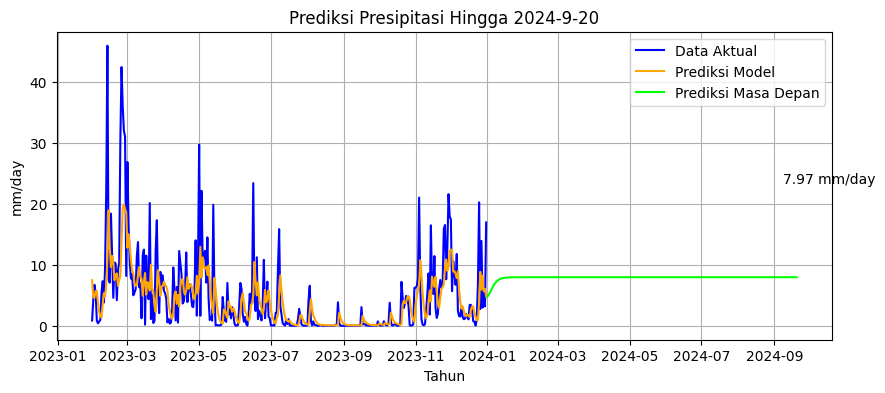

In [18]:
# --- VISUALISASI HASIL PREDIKSI ---
plt.figure(figsize=(10, 4))
plt.plot(df.index[len(X_train) + timesteps:], y_test_inv, label='Data Aktual', color='blue')
plt.plot(df.index[len(X_train) + timesteps:], y_pred_inv, label='Prediksi Model', color='orange')
plt.plot(future_dates, future_preds, label='Prediksi Masa Depan', color='lime', linestyle='-')

# Anotasi prediksi pada target_date
plt.annotate(f'{future_preds[-1][0]:.2f} {metrics_dict[feature]}',
             xy=(future_dates[-1], future_preds[1][0]),
             xytext=(-10, 80),
             textcoords='offset points')

plt.xlabel('Tahun')
plt.ylabel(metrics_dict[feature])
plt.title(f'Prediksi {feature_name} Hingga {target_date}')
plt.grid(True)
plt.legend()
plt.show()

## Save Model
Save model dalam file berformat h5, pickle, dan Keras

In [19]:
import pickle

# Save Model
model_path = rf"C:\Users\Pujo Prayogo\Desktop\Kuliah\SKRIPSI\Kode\model/model_{feature_name}"

best_model.save(model_path+".h5")
best_model.save(model_path+".keras")
pickle.dump(best_model, open(f"best_{feature_name}_model.pkl", "wb"))
best_model.export(f"model_{feature_name}")

print(f'model h5 tersimpan di {model_path + ".h5"}')
print(f'model keras tersimpan di {model_path + ".keras"}')
print(f'model pickle tersimpan di {model_path + ".pkl"}')
print(f'model tersimpan di folder {model_path}')

INFO:tensorflow:Assets written to: model_Presipitasi\assets


INFO:tensorflow:Assets written to: model_Presipitasi\assets


Saved artifact at 'model_Presipitasi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1558290929968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558291110192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558291179296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558291269232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558291341728: TensorSpec(shape=(), dtype=tf.resource, name=None)
model h5 tersimpan di C:\Users\Pujo Prayogo\Desktop\Kuliah\SKRIPSI\Kode\model/model_Presipitasi.h5
model keras tersimpan di C:\Users\Pujo Prayogo\Desktop\Kuliah\SKRIPSI\Kode\model/model_Presipitasi.keras
model pickle tersimpan di C:\Users\Pujo Prayogo\Desktop\Kuliah\SKRIPSI\Kode\model/model_Presipitasi.pkl
model tersimpan di folder C:\Users\Pujo Prayogo\Desktop\Kuliah\SKRIPSI\Ko